In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import multinomial
from scipy.stats import logistic
from scipy.stats import expon, uniform, laplace
from Main_functions import *
import random
from numpy import genfromtxt

### Setting the data distribuation 

Pairs $(x_i,y_i)\in \mathbb{R}^d\times \mathbb{R}^d$ for $i=1, \ldots, N$ are generated i.i.d. from density distribuation $f(\cdot)\times f(\cdot)$.  

Parameters:

$d:$ dimention of data points

$N:$ number of pairs

$f(\cdot):$ density distribuation


### Given the eigenvalues of ground truth $M_t$, we randomly generate it.

In [2]:
csv_path = 'CSVs/noisy_labeling_logistic_'
image_path = 'Images/noisy_labeling_logistic_'
title_suffix = '\n (Noisy_labeling Logistic model)'
noise_type = 'Noisy_labeling'
model_type = 'Logistic'

In [3]:
d = 10
rank = 5
seed = 2023

In [4]:
np.random.seed(seed)
non_zero_eigens_of_M_star = np.round(np.random.uniform(low=0.0, high=1.0, size= rank), 2)

In [5]:
#random.seed(seed)
# non_zero_eigens_of_M_star = random.choices(np.arange(1, 31), k = rank)
# random.uniform()
non_zero_eigens_of_M_star

array([0.32, 0.89, 0.59, 0.13, 0.14])

In [6]:
diag = np.zeros(d)
diag[:rank] = non_zero_eigens_of_M_star
diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [7]:
data_model = DG(diag, seed = 22)

Ground truth M_t and B_t are generated (M_t = B_t @ B_t.T)
To access to M_t and B_t, use .M_t and .B_t


In [8]:
data_model.M_diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [9]:
data_model.M_t.shape, data_model.B_t.shape

((10, 10), (10, 10))

### Given the eigenvalue of covariance matrix Cov, we randomly generate it.

In [10]:
np.random.seed(2024)
diag_cov = np.round(np.random.uniform(low=0.0, high=1.0, size= d), 2)

In [11]:
print(diag_cov)

[0.59 0.7  0.19 0.04 0.21 0.11 0.73 0.68 0.47 0.45]


In [12]:
# diag_cov.sort()

In [13]:
print(diag_cov)

[0.59 0.7  0.19 0.04 0.21 0.11 0.73 0.68 0.47 0.45]


In [14]:
diag_cov.sum()

4.17

In [15]:
Sigma, U_sigma = random_covariance(diag_cov, seed = 21)

In [16]:
f = multivariate_normal(mean = np.zeros(d), cov = Sigma)

### What is the average of squared norm of points generating where $x\sim f(x)$ with $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$

If $x\sim f(x)$ where $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$, then 
\begin{align}
\mathbb{E}\left(x^\top Mx\right) & = \mathbb{E}\left({\rm tr}(x^\top Mx)\right)\\
 & = \mathbb{E}\left({\rm tr}(xx^\top M)\right)\\
 & = {\rm tr}\left(\mathbb{E}\left(xx^\top\right)M\right)\\
 & = {\rm tr}\left(\left[{\rm Cov}(x) - \mathbb{E}(x)\mathbb{E}(x)^\top\right]M\right)
\end{align}

If we set  $\mu = \mathbf{0}$, then 
$$\mathbb{E}\left(x^\top Mx\right) = {\rm tr}\left(\Sigma M\right).$$
Therefore, since $x$ and $y$ are independent, 
$$\mathbb{E}\left(\|x-y\|_M^2\right) = 2{\rm tr}\left(\Sigma M\right).$$

$$\mathbb{E}\left((x-y)^\top (x-y)\right) = \mathbb{E}\left(x^\top x + y^\top y - x^\top y - y^\top x\right) = 2{\rm Cov}(x)$$

In [17]:
snm = 2 * np.trace(data_model.M_t @ Sigma)
print("squared norm mean = {}".format(snm))

squared norm mean = 1.6983720913430767


### Check the average empirically

In [18]:
N = 10000
X_1, Y_1 = sample(f, N)
sn = (((X_1 - Y_1) @ data_model.B_t)**2).sum()/N
print("emperical squared norm mean = {}".format(sn))

emperical squared norm mean = 1.7357384841106784


### Set $\tau$ to generate data points (binary case!)

In [19]:
tau = [1.3]
N = 20000
noise = 0.20

In [20]:
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                                noise_type = noise_type, noise_par = noise)

In [21]:
noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

the amount of noise: 0.098


In [22]:
for i in range(len(tau)+1):
    print('number of pairs with {} as their labels is {}'.format(i, (D_no_noisy==i).sum()))

number of pairs with 0 as their labels is 10251
number of pairs with 1 as their labels is 9749


In [23]:
(D_no_noisy== 0).sum()/N

0.51255

### Change to PyTorch tensor!

In [24]:
X = torch.tensor(X, dtype = torch.float64)
Y = torch.tensor(Y, dtype = torch.float64)
D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)

In [25]:
X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
                                                                                                 Y, 
                                                                                                 D_noisy, 
                                                                                                 D_no_noisy, 
                                                                                                 n_train = 15000)

In [26]:
X.dtype, D.dtype

(torch.float64, torch.int64)

## Set the model and train it

In [27]:
k = 10
n_labels = len(tau) + 1

In [28]:
model = ML(d, k, n_labels, 
   X_T, Y_T, D_T, D_no_noise_T, 
   X_test, Y_test, D_test, D_no_noise_test, Type = model_type)

In [29]:
model.train(learning_rate = 5e-1, 
            n_iters = 30001, 
            decay = .95,
            f = f, 
            B_star = data_model.B_t, 
            tau_star = data_model.tau_t, 
            N = 1000)
# N here is used to generate N samples to estimate L_1_f_norm

Starting Tau:  tensor([0.9324], dtype=torch.float64, requires_grad=True)
epoch 0: loss = 0.7832992919859877
train accuracy with noise 0.5158666666666667
train accuracy without noise 0.5148
test accuracy with noise 0.5014
test accuracy without noise 0.5058
epoch 5000:
 norm of B.grad = 1.219306113756254e-08,
 loss = 0.44905772270925903
tensor([3.0167], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.8577333333333333
train accuracy without noise 0.9409333333333333
test accuracy with noise 0.8482
test accuracy without noise 0.9398
epoch 10000:
 norm of B.grad = 1.8578241670600778e-13,
 loss = 0.44902134598925586
tensor([3.0337], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.8576666666666667
train accuracy without noise 0.941
test accuracy with noise 0.8482
test accuracy without noise 0.9394
epoch 15000:
 norm of B.grad = 1.9434771055640675e-19,
 loss = 0.44902134595859
tensor([3.0337], dtype=torch.float64, requires_grad=True)
train accuracy with

In [30]:
X_new, Y_new, _, D_new = data_model.generate(f, 
                                             N = 10000, 
                                             tau = np.array(tau), 
                                             noise_type = None, 
                                             noise_par = None)

In [31]:
X_new = torch.tensor(X_new, dtype = torch.float64)
Y_new = torch.tensor(Y_new, dtype = torch.float64)
D_new = torch.tensor(D_new, dtype = torch.torch.int64)

In [32]:
ac_unseen = model.accuracy(X_new, Y_new, D_new)
print('accuracy on unseen data {}'.format(ac_unseen))

accuracy on unseen data 0.9437


In [33]:
# M_hat = (model.B @ model.B.T).detach().numpy()*s
# M_star = data_model.M_t
# tau_hat = model.Tau.detach().numpy()[0]*s
# tau_star = data_model.tau_t[0]

# print((np.abs(M_hat - M_star)).max())
# print(np.abs(tau_hat-tau_star))

### Error bars

In [34]:
n_runs = 20
N = 20000
n_train = 15000

In [35]:
models_list = []
for i in range(n_runs):
    print('round i = {} started'.format(i))
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = gen_data(f, 
                                                                                         N, 
                                                                                         n_train, 
                                                                                         tau = np.array(tau), 
                                                                                         noise_type = noise_type,
                                                                                         noise_par = noise,
                                                                                         data_model = data_model)
    model = ML(d, k, n_labels, 
               X_T, Y_T, D_T, D_no_noise_T, 
               X_test, Y_test, D_test, 
               D_no_noise_test, Type = model_type) 
    
    model.train(learning_rate = 5e-1, 
                n_iters = 30001, 
                decay = .95,
                f = f, 
                B_star = data_model.B_t, 
                tau_star = data_model.tau_t, 
                N = 1000,
               show_log = False)
    models_list.append(model)

round i = 0 started
round i = 1 started
round i = 2 started
round i = 3 started
round i = 4 started
round i = 5 started
round i = 6 started
round i = 7 started
round i = 8 started
round i = 9 started
round i = 10 started
round i = 11 started
round i = 12 started
round i = 13 started
round i = 14 started
round i = 15 started
round i = 16 started
round i = 17 started
round i = 18 started
round i = 19 started


In [36]:
M_hat_normal_list = [models_list[i].B @ models_list[i].B.T / models_list[i].Tau[0] for i in range(n_runs)]

In [37]:
eigen_list_M_hat_normal = np.array([LA.svd(M_hat_normal_list[i].detach().numpy(), full_matrices=False)[1] 
                                for i in range(n_runs)])
eigen_list_M_hat_normal.shape

(20, 10)

In [38]:
mean_eigens = eigen_list_M_hat_normal.mean(axis = 0)

In [39]:
std_eigens = eigen_list_M_hat_normal.std(axis = 0)

In [40]:
M_t_normal = data_model.M_t/tau[0]
U_t, S_t, V_t = LA.svd(M_t_normal, full_matrices=False)

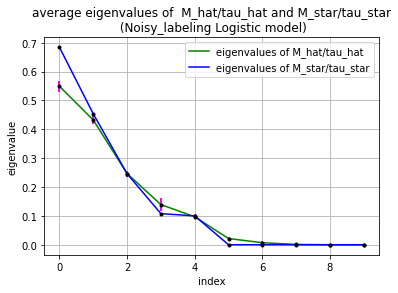

In [41]:
plot_with_y_error_bar(x= [i for i in range(d)], 
                      y = eigen_list_M_hat_normal, 
                      z = S_t, 
                      x_label = 'index', 
                      y_label = 'eigenvalue', 
                      title = 'average eigenvalues of  M_hat/tau_hat and M_star/tau_star' + title_suffix, 
                      xy_label = 'eigenvalues of M_hat/tau_hat', 
                      xz_label = 'eigenvalues of M_star/tau_star',
                      save_path = image_path + "mean_eigen")

### Error Mean

In [42]:
mean_train_accuracy_with_noise = np.mean([model.train_accuracy_with_noise[-1] for model in models_list])
mean_train_accuracy_without_noise = np.mean([model.train_accuracy_without_noise[-1] for model in models_list])
mean_test_accuracy_with_noise = np.mean([model.test_accuracy_with_noise[-1] for model in models_list])
mean_test_accuracy_without_noise = np.mean([model.test_accuracy_without_noise[-1] for model in models_list])

print('mean_train_accuracy_with_noise = {}'.format(mean_train_accuracy_with_noise))
print('mean_train_accuracy_without_noise = {}'.format(mean_train_accuracy_without_noise))
print('mean_test_accuracy_with_noise = {}'.format(mean_test_accuracy_with_noise))
print('mean_test_accuracy_without_noise = {}'.format(mean_test_accuracy_without_noise))

mean_train_accuracy_with_noise = 0.8573366666666666
mean_train_accuracy_without_noise = 0.9467833333333333
mean_test_accuracy_with_noise = 0.8556500000000001
mean_test_accuracy_without_noise = 0.94513


### Spectrual norm 
$$\frac{\left\|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right\|_2}{\left\|\frac{M^*}{\tau^*}\right\|_2}$$

In [43]:
def d_metric(M_1, t_1, M_2 = None, t_2 = None):
    if M_2 is None:
        _, E, _ = LA.svd(M_1, full_matrices=False)
        return E[0]+t_1
    else:
        _, E, _ = LA.svd(M_1 - M_2, full_matrices=False)
        return E[0] + np.abs(t_1-t_2)     

In [44]:
Average_Spectral_norm = np.mean([d_metric(M_hat_normal.detach().numpy(), 0, M_t_normal, 0)/d_metric(M_t_normal, 0) 
                                          for M_hat_normal in M_hat_normal_list])

In [45]:
print('Average_Spectral_norm = ', Average_Spectral_norm)

Average_Spectral_norm =  0.23132480477313822


### Relative errors

### Frobenius norm

$$\frac{\left\|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right\|_F}{\left\|\frac{M^*}{\tau^*}\right\|_F}$$

In [46]:
F_R = lambda M_1, M_2: LA.norm(M_1 - M_2)/LA.norm(M_1)
Average_Frobenius_norm = np.mean([F_R(M_t_normal, M_hat_normal.detach().numpy()) 
                                          for M_hat_normal in M_hat_normal_list])
print('Average_Frobenius_norm = ', Average_Frobenius_norm)

Average_Frobenius_norm =  0.2140245118881489


In [47]:
M_hat_normal = model.B @ model.B.T / model.Tau[0]
M_t_normal = data_model.M_t/tau[0]

In [48]:
np.sqrt(np.sum((M_t_normal - M_hat_normal.detach().numpy())**2))/np.sqrt((M_t_normal**2).sum())

0.1719215531253026

$$\left\|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right\|_\infty$$

In [49]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).max()

0.0357770553408083

$$\left|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right|_{L_1(f)}$$

In [50]:
L_1_f_norm(f, model.B.detach().numpy(), model.Tau.detach().numpy(), 
           data_model.B_t, data_model.tau_t, N = 10000)

0.16938941083553222

$$\left|\hat{\tau} - \frac{\tau^*}{s}\right|$$

In [51]:
# np.abs(model.Tau.detach().numpy()[0] - data_model.tau_t[0]/s)

$$\frac{\left|\hat{\tau} - \frac{\tau^*}{s}\right|}{\frac{\tau^*}{s}}$$

In [52]:
# np.abs(model.Tau.detach().numpy()[0] - data_model.tau_t[0]/s)/ (data_model.tau_t[0]/s)

In [53]:
# model.Tau.detach().numpy()[0], data_model.tau_t[0]/s

In [54]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).max()

0.0357770553408083

In [55]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).mean()

0.010684963541743343

In [56]:
np.sqrt(np.sum((M_t_normal - M_hat_normal.detach().numpy())**2))/np.sqrt((M_t_normal**2).sum())

0.1719215531253026

In [57]:
np.sqrt((M_t_normal**2).sum())

0.8699792556868479

In [58]:
print(model.Tau.detach().numpy())
print(np.array(tau))
print(model.Tau.detach().numpy()[0]/np.array(tau)[0])

[2.86618994]
[1.3]
2.2047614950197953


In [59]:
# B_star_normal = data_model.B_t/np.sqrt(tau[0])
# B_hat_normal = model.B.detach().numpy() /np.sqrt(model.Tau.detach().numpy()[0])

In [60]:
# def L_1_f_norm(f, B, tau, B_hat, tau_hat, N = 10000):
#     B_star_normal = B / np.sqrt(tau[0])
#     B_hat_normal = B_hat /np.sqrt(tau_hat[0])
#     X, Y = sample(f, N)
#     Z = X - Y 
#     temp = ((Z @ B_star_normal)**2).sum(axis = 1) - ((Z @ B_hat_normal)**2).sum(axis = 1)
#     return np.abs(temp).mean()

In [61]:
# def L_1_f_norm(f, B_star_normal, B_hat_normal, N = 10000):
#     X, Y = sample(f, N)
#     Z = X - Y 
#     temp = ((Z @ B_star_normal)**2).sum(axis = 1) - ((Z @ B_hat_normal)**2).sum(axis = 1)
#     return np.abs(temp).mean()  

In [62]:
L_1_f_norm(f, model.B.detach().numpy(), model.Tau.detach().numpy(), 
           data_model.B_t, data_model.tau_t, N = 10000)

0.17165801384349794

In [63]:
# def L_1_f_norm_new(f, B, tau, B_hat, tau_hat, N = 10000):
#     X, Y = sample(f, N)
#     Z = X - Y 
#     temp = ((Z @ B)**2).sum(axis = 1) - tau[0] - ((Z @ B_hat)**2).sum(axis = 1) + tau_hat[0]
#     return np.abs(temp).mean() 

In [64]:
# L_1_f_norm_new(f, data_model.B_t, data_model.tau_t,
#                model.B.detach().numpy()*np.sqrt(s), model.Tau.detach().numpy()*s, N = 10000)

In [65]:
# print(loss(X_T - Y_T, D_T, data_model.B_t/np.sqrt(s), data_model.tau_t/s, Type = model_type).item())
# print(loss(X_T - Y_T, D_T, model.B, model.Tau, Type = model_type).item())
# print(model.loss_history[-1].item())

In [66]:
print(loss(X_T - Y_T, D_T, data_model.B_t/data_model.tau_t[0], np.zeros(1), Type = model_type).item())
print(loss(X_T - Y_T, D_T, model.B/model.Tau[0], np.zeros(1), Type = model_type).item())

0.6454313211439047
0.6406142446297333


In [67]:
Pred_test = pred(X_test, Y_test, data_model.B_t, np.array(tau))
print("test accuracy with noise (Using ground truth) = ", (Pred_test == D_test).sum().item()/D_test.shape[0])
print("test accuracy without noise (Using ground truth) = ", (Pred_test == D_no_noise_test).sum().item()/D_no_noise_test.shape[0])

test accuracy with noise (Using ground truth) =  0.8952
test accuracy without noise (Using ground truth) =  1.0


In [68]:
Pred_test = pred(X_test, Y_test, model.B, model.Tau)
print("test accuracy with noise", (Pred_test == D_test).sum().item()/D_test.shape[0])
print("test accuracy without noise", (Pred_test == D_no_noise_test).sum().item()/D_no_noise_test.shape[0])

test accuracy with noise 0.853
test accuracy without noise 0.9458


In [69]:
U_hat, S_hat, V_hat = LA.svd(M_hat_normal.detach().numpy(), full_matrices=False)

In [70]:
U_t, S_t, V_t = LA.svd(M_t_normal, full_matrices=False)

In [71]:
S_hat.sum(), S_t.sum()

(1.4674574959117708, 1.5923076923076906)

In [72]:
S_hat

array([5.65348508e-01, 4.13938735e-01, 2.28599539e-01, 1.18869313e-01,
       1.01448350e-01, 3.02812579e-02, 8.97179319e-03, 2.12302396e-17,
       9.68016902e-18, 2.80484043e-18])

In [73]:
S_t

array([6.84615385e-01, 4.53846154e-01, 2.46153846e-01, 1.07692308e-01,
       1.00000000e-01, 4.36695175e-17, 2.06400798e-17, 1.41402615e-17,
       1.24080830e-17, 2.09411824e-18])

In [74]:
((S_hat - S_t)**2).sum()

0.017249814377148003

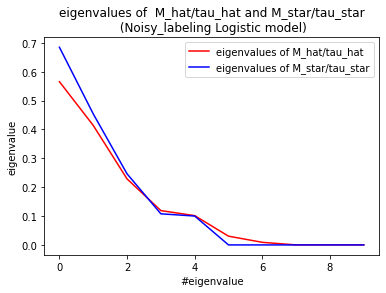

In [75]:
plt.plot(S_hat, label = 'eigenvalues of M_hat/tau_hat', color= 'red')
plt.plot(S_t, label = 'eigenvalues of M_star/tau_star', color = 'blue')
plt.legend()
plt.xlabel('#eigenvalue', fontsize=10)
plt.ylabel('eigenvalue', fontsize=10)
plt.title('eigenvalues of  M_hat/tau_hat and M_star/tau_star' + title_suffix, fontsize= 12)
plt.savefig(image_path + "eigen", bbox_inches='tight')
plt.show()

In [76]:
np.savetxt(csv_path + "eigen_S_star_normal.csv", 
           S_t,
           delimiter =", ", 
           fmt ='% s')
np.savetxt(csv_path + "eigen.csv", 
           S_hat,
           delimiter =", ", 
           fmt ='% s')

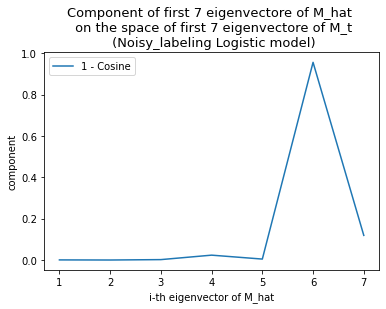

In [77]:
H = []
m = 7
for i in range(m):
    H.append(proj(U_hat[:, i], U_t[:, :m]))
    
plt.plot([j+1 for j in range(m)], H, label = '1 - Cosine')
plt.legend()
plt.xlabel('i-th eigenvector of M_hat', fontsize=10)
plt.ylabel('component', fontsize=10)
plt.title('Component of first {} eigenvectore of M_hat \n on the space of first {} eigenvectore of M_t'.format(m, m) + title_suffix, 
          fontsize= 13)
plt.savefig(image_path + "Cosine", bbox_inches='tight')
plt.show()

In [78]:
np.savetxt(csv_path + "Cosine.csv", 
           H,
           delimiter =", ", 
           fmt ='% s')

In [79]:
for i in range(d):
    print(np.dot(U_hat[:,i], U_t[:,i]))

0.9886565459967023
0.9878716207267323
0.9955476896010116
-0.6792170555137254
-0.6951218280815811
0.16158052108772897
-0.7686349535533362
0.2316491915738027
0.2374684030177592
0.6158906063241618


In [80]:
np.diag(U_hat.T @ U_t)

array([ 0.98865655,  0.98787162,  0.99554769, -0.67921706, -0.69512183,
        0.16158052, -0.76863495,  0.23164919,  0.2374684 ,  0.61589061])

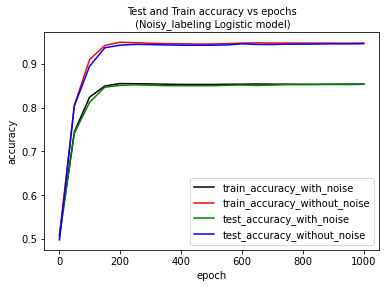

In [81]:
I = model.epoch_history
plt.plot(I[:21], model.train_accuracy_with_noise[:21], label = 'train_accuracy_with_noise', color = 'black')
plt.plot(I[:21], model.train_accuracy_without_noise[:21], label = 'train_accuracy_without_noise', color = 'red')
plt.plot(I[:21], model.test_accuracy_with_noise[:21], label = 'test_accuracy_with_noise', color = 'green')
plt.plot(I[:21], model.test_accuracy_without_noise[:21], label = 'test_accuracy_without_noise', color = 'blue')
plt.legend()

plt.xlabel('epoch', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('Test and Train accuracy vs epochs' + title_suffix, fontsize=10)
plt.savefig(image_path + "Test_and_Train_accuracy_vs_epochs", bbox_inches='tight')
plt.show()

In [82]:
np.savetxt(csv_path + "model_epoch_history.csv", 
           model.epoch_history,
           delimiter =", ", 
           fmt ='% s')

In [83]:
np.savetxt(csv_path + "model_train_accuracy_with_noise.csv", 
           model.train_accuracy_with_noise,
           delimiter =", ", 
           fmt ='% s')

In [84]:
np.savetxt(csv_path + "model_train_accuracy_without_noise.csv", 
           model.train_accuracy_without_noise,
           delimiter =", ", 
           fmt ='% s')

In [85]:
np.savetxt(csv_path + "model_test_accuracy_with_noise.csv", 
           model.test_accuracy_with_noise,
           delimiter =", ", 
           fmt ='% s')

In [86]:
np.savetxt(csv_path + "model_test_accuracy_without_noise.csv", 
           model.test_accuracy_without_noise,
           delimiter =", ", 
           fmt ='% s')

In [87]:
model.loss_history[-1]

tensor(0.4568, dtype=torch.float64)

In [88]:
s_prime = np.array(tau)[0]/model.Tau.detach().numpy()[0]
print(s_prime)

0.453563799194988


In [89]:
l_value = loss(X_T - Y_T, D_T, data_model.B_t/np.sqrt(s_prime), data_model.tau_t/s_prime, Type = model_type).item()
I_ = np.array([l_value for _ in I])

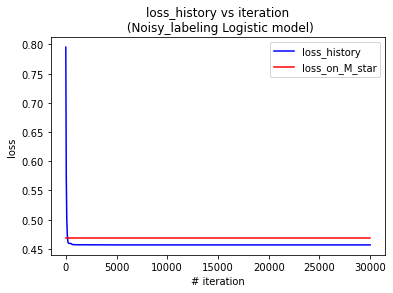

In [90]:
plt.plot(I[:], model.loss_history[:], label = 'loss_history', color = 'blue')
plt.plot(I[:], I_[:], label = 'loss_on_M_star', color = 'red')
plt.legend()
plt.xlabel('# iteration', fontsize=10)
plt.ylabel('loss', fontsize=10)
plt.title('loss_history vs iteration' + title_suffix, fontsize=12)
plt.savefig(image_path + "loss_history_vs_iteration", bbox_inches='tight')
plt.show()

In [91]:
np.savetxt(csv_path + "index_loss_history.csv", 
           I,
           delimiter =", ", 
           fmt ='% s')

In [92]:
np.savetxt(csv_path + "model.loss_history.csv", 
           model.loss_history,
           delimiter =", ", 
           fmt ='% s')

In [93]:
np.savetxt(csv_path + "true_loss_history.csv", 
           I_,
           delimiter =", ", 
           fmt ='% s')

In [94]:
model.L_1_f_norm_history[-1]

0.17593560676554726

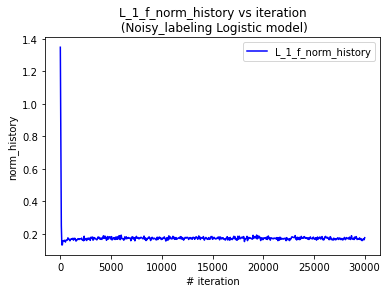

In [95]:
plt.plot(I[:], model.L_1_f_norm_history[:], label = 'L_1_f_norm_history', color = 'blue')
plt.legend()
plt.xlabel('# iteration', fontsize=10)
plt.ylabel('norm_history', fontsize=10)
plt.title('L_1_f_norm_history vs iteration' + title_suffix, fontsize=12)
plt.savefig(image_path + "norm_history_vs_iteration", bbox_inches='tight')
plt.show()

In [96]:
np.savetxt(csv_path + "model_L_1_f_norm_history.csv", 
           model.L_1_f_norm_history,
           delimiter =", ", 
           fmt ='% s')

## Sample complexity

In [97]:
k = 10
n_labels = len(tau)+1

In [98]:
H = []
J = []
N = 0
while N <= 10000:
    if N < 100:
        N += 10
    elif N < 1000:
        N += 100
    elif N < 5000:
        N+= 1000
    else: N += 5000
    
    
    X, Y, D_noisy, D_no_noisy = data_model.generate(f, 
                                                    N + 2000, 
                                                    tau = np.array(tau), 
                                                    noise_type = noise_type, 
                                                    noise_par = noise)
    X = torch.tensor(X, dtype = torch.float64)
    Y = torch.tensor(Y, dtype = torch.float64)
    D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
    D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)
        
    print('round for N = {} has started'.format(N))
    
    J.append(N)
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
                                                                                                     Y, 
                                                                                                 D_noisy, 
                                                                                                 D_no_noisy, 
                                                                                                 n_train = N)

    
    model = ML(d, k, n_labels, 
               X_T, Y_T, 
               D_T, D_no_noise_T, 
               X_test, Y_test, 
               D_test, D_no_noise_test, 
               Type = model_type) 
    
    model.train(learning_rate = 1e-1, 
                n_iters = 30000, 
                decay = .96, 
                show_log = False)
    H.append(model)

round for N = 10 has started
round for N = 20 has started
round for N = 30 has started
round for N = 40 has started
round for N = 50 has started
round for N = 60 has started
round for N = 70 has started
round for N = 80 has started
round for N = 90 has started
round for N = 100 has started
round for N = 200 has started
round for N = 300 has started
round for N = 400 has started
round for N = 500 has started
round for N = 600 has started
round for N = 700 has started
round for N = 800 has started
round for N = 900 has started
round for N = 1000 has started
round for N = 2000 has started
round for N = 3000 has started
round for N = 4000 has started
round for N = 5000 has started
round for N = 10000 has started
round for N = 15000 has started


In [99]:
H[-1].accuracy(X_new, Y_new, D_new)

0.9514

In [100]:
test_accuracy_no_noise  = [H[i].accuracy(X_new, Y_new, D_new) for i in range(len(H))]

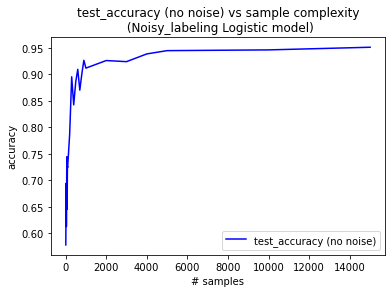

In [101]:
plt.plot(J, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (no noise) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "test_accuracy_no_noise_vs_sample_complexity", bbox_inches='tight')
plt.show()

In [102]:
np.savetxt(csv_path + "test_accuracy_no_noise.csv", 
           test_accuracy_no_noise,
           delimiter =", ", 
           fmt ='% s')

In [103]:
np.savetxt(csv_path + "number_samples_list.csv", 
           J,
           delimiter =", ", 
           fmt ='% s')

In [104]:
test_accuracy_noisy  = [H[i].accuracy(H[i].X_test, H[i].Y_test, H[i].D_test) for i in range(len(H))]

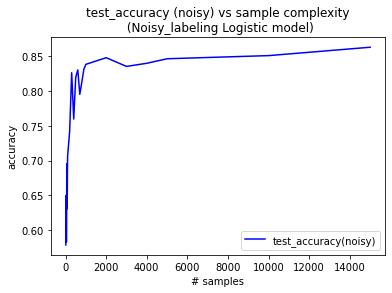

In [105]:
plt.plot(J, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (noisy) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "test_accuracy_noisy_vs_sample_complexity", bbox_inches='tight')
plt.show()

In [106]:
np.savetxt(csv_path + "test_accuracy_noisy.csv", 
           test_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [107]:
train_accuracy_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_T) for i in range(len(H))]

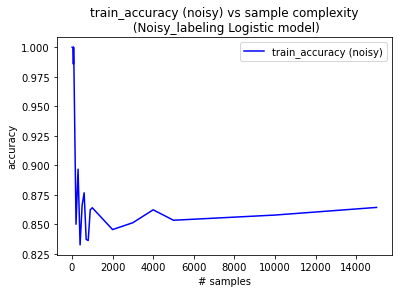

In [108]:
plt.plot(J, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (noisy) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "train_accuracy_noisy_vs_sample_complexity", bbox_inches='tight')
plt.show()

In [109]:
np.savetxt(csv_path + "train_accuracy_noisy.csv", 
           train_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [110]:
train_accuracy_no_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_no_noise_T) for i in range(len(H))]

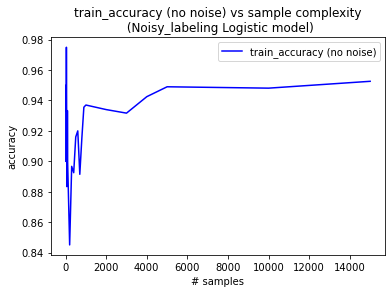

In [111]:
plt.plot(J, train_accuracy_no_noisy, label = 'train_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (no noise) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "train_accuracy_no_noise_vs_sample_complexity", bbox_inches='tight')
plt.show()

### 

In [112]:
np.savetxt(csv_path + "train_accuracy_no_noisy.csv", 
           train_accuracy_no_noisy,
           delimiter =", ", 
           fmt ='% s')

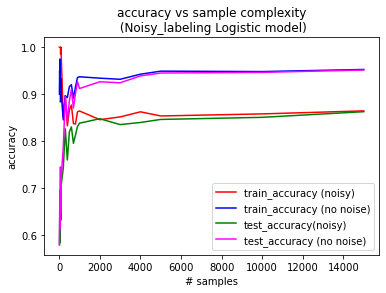

In [113]:
plt.plot(J, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'red')
plt.plot(J, train_accuracy_no_noisy, label = 'train_accuracy (no noise)', color = 'blue')
plt.plot(J, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'green')
plt.plot(J, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'magenta')

plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('accuracy vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "accuracy_vs_sample_complexity", bbox_inches='tight')
plt.show()

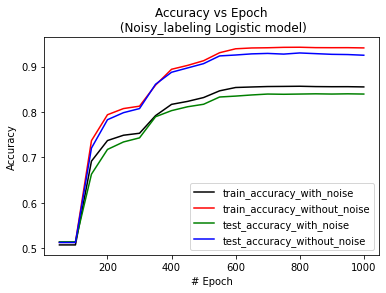

In [114]:
I = H[-1].epoch_history[:]
plt.plot(I[1:21], H[-1].train_accuracy_with_noise[1:21], label = 'train_accuracy_with_noise', color = 'black')
plt.plot(I[1:21], H[-1].train_accuracy_without_noise[1:21], label = 'train_accuracy_without_noise', color = 'red')
plt.plot(I[1:21], H[-1].test_accuracy_with_noise[1:21], label = 'test_accuracy_with_noise', color = 'green')
plt.plot(I[1:21], H[-1].test_accuracy_without_noise[1:21], label = 'test_accuracy_without_noise', color = 'blue')
plt.legend()
plt.xlabel('# Epoch', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy vs Epoch' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'Accuracy_vs_Epoch', bbox_inches='tight')
plt.show()

## How much noise breaks the model!

In [115]:
N = 20000

In [116]:
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N = 20000, tau = np.array(tau), 
                                          noise_type = noise_type, noise_par = 50)
noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

the amount of noise: 0.49615


In [117]:
(D_no_noisy == 0).sum(), (D_no_noisy == 1).sum(), (D_no_noisy == 1).sum()/N

(10074, 9926, 0.4963)

In [118]:
noise_list = 2 * genfromtxt('CSVs/logistic_logistic_noise_list_history.csv', delimiter = ',')

In [119]:
# np.savetxt("CSVs/logistic/scale_list.csv", 
#            noise_par_list,
#            delimiter =", ", 
#            fmt ='% s')

In [120]:
N = 28000
d = 10
k = 10
n_labels = len(tau) + 1
noise_list_history = []
model_history = []
for noise in noise_list:
    X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                                    noise_type = noise_type, noise_par = noise)
    noise_amount = (D_noisy != D_no_noisy).mean()
    print('the amount of noise: {}'.format(noise_amount))
    noise_list_history.append(noise_amount)
    
    X = torch.tensor(X, dtype = torch.float64)
    Y = torch.tensor(Y, dtype = torch.float64)
    D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
    D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)
    
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X,
                                                                                                     Y, 
                                                                                                     D_noisy, 
                                                                                                     D_no_noisy, 
                                                                                                     n_train = 18000)
    model = ML(d, k, n_labels, 
               X_T, Y_T, D_T, D_no_noise_T,
               X_test, Y_test, D_test, D_no_noise_test, Type = model_type)
    
    model.train(learning_rate = 1e-1, 
                n_iters = 30001, 
                decay = .95, 
                show_log = False)
    
    model_history.append(model)
    
    print('train_accuracy (noisey) = {}'.format(model_history[-1].accuracy(model_history[-1].X_T, 
                                                                           model_history[-1].Y_T, 
                                                                           model_history[-1].D_T)))
    
    print('test_accuracy (noisey) = {}'.format(model_history[-1].accuracy(model_history[-1].X_test, 
                                                                          model_history[-1].Y_test, 
                                                                          model_history[-1].D_test)))
    
    print('train_accuracy (no noise) = {}'.format(model_history[-1].accuracy(model_history[-1].X_T, 
                                                                             model_history[-1].Y_T, 
                                                                             model_history[-1].D_no_noise_T)))
    
    print('test_accuracy (no noise) = {}'.format(model_history[-1].accuracy(model_history[-1].X_test, 
                                                                            model_history[-1].Y_test, 
                                                                            model_history[-1].D_no_noise_test)))
    print('\n')

the amount of noise: 0.0
train_accuracy (noisey) = 0.9973888888888889
test_accuracy (noisey) = 0.997
train_accuracy (no noise) = 0.9973888888888889
test_accuracy (no noise) = 0.997


the amount of noise: 0.047964285714285716
train_accuracy (noisey) = 0.9309444444444445
test_accuracy (noisey) = 0.9279
train_accuracy (no noise) = 0.9751111111111112
test_accuracy (no noise) = 0.9757


the amount of noise: 0.09696428571428571
train_accuracy (noisey) = 0.8641666666666666
test_accuracy (noisey) = 0.8585
train_accuracy (no noise) = 0.9516111111111111
test_accuracy (no noise) = 0.947


the amount of noise: 0.14682142857142857
train_accuracy (noisey) = 0.8053333333333333
test_accuracy (noisey) = 0.81
train_accuracy (no noise) = 0.9291111111111111
test_accuracy (no noise) = 0.9343


the amount of noise: 0.18521428571428572
train_accuracy (noisey) = 0.7655555555555555
test_accuracy (noisey) = 0.7615
train_accuracy (no noise) = 0.9188888888888889
test_accuracy (no noise) = 0.9195


the amount of n

In [121]:
np.savetxt(csv_path + "noise_list_history.csv", 
           noise_list_history,
           delimiter =", ", 
           fmt ='% s')

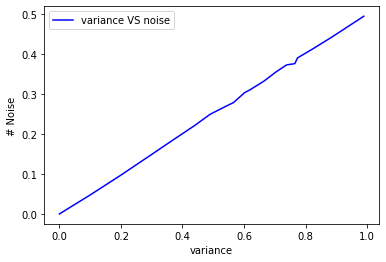

In [122]:
plt.plot(noise_list, noise_list_history, label = 'variance VS noise', color = 'blue')
plt.legend()
plt.ylabel('# Noise', fontsize = 10)
plt.xlabel('variance', fontsize = 10)
# plt.title('unseen_accuracy (no noise) vs sample complexity', fontsize = 10)
plt.show()

In [123]:
X_new, Y_new, _, D_new = data_model.generate(f, 
                                             N = 10000, 
                                             tau = np.array(tau), 
                                             noise_type = None, 
                                             noise_par = None)
X_new = torch.tensor(X_new, dtype = torch.float64)
Y_new = torch.tensor(Y_new, dtype = torch.float64)
D_new = torch.tensor(D_new, dtype = torch.torch.int64)

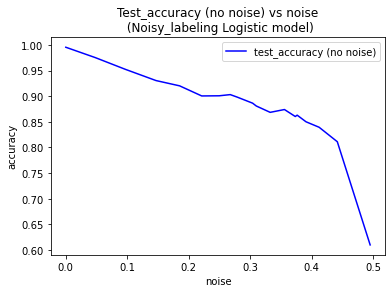

In [124]:
test_accuracy_no_noise  = [model_history[i].accuracy(X_new, Y_new, D_new) for i in range(len(model_history))]

plt.plot(noise_list_history, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('Test_accuracy (no noise) vs noise' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'Test_accuracy_no_noise_vs_noise', bbox_inches='tight')
plt.show()

In [125]:
np.savetxt(csv_path + "test_accuracy_no_noise.csv", 
           test_accuracy_no_noise,
           delimiter =", ", 
           fmt ='% s')

In [126]:
[(noise_list_history[i], test_accuracy_no_noise[i]) for i in range(len(noise_list_history))]

[(0.0, 0.9954),
 (0.047964285714285716, 0.9752),
 (0.09696428571428571, 0.9523),
 (0.14682142857142857, 0.9304),
 (0.18521428571428572, 0.9201),
 (0.22117857142857142, 0.9004),
 (0.24960714285714286, 0.9007),
 (0.2676428571428571, 0.903),
 (0.2789642857142857, 0.8981),
 (0.304, 0.8863),
 (0.3099642857142857, 0.8808),
 (0.3325714285714286, 0.8684),
 (0.35582142857142857, 0.8739),
 (0.37342857142857144, 0.8603),
 (0.3765, 0.8629),
 (0.39089285714285715, 0.85),
 (0.41225, 0.8393),
 (0.4418214285714286, 0.8111),
 (0.4952857142857143, 0.6098)]

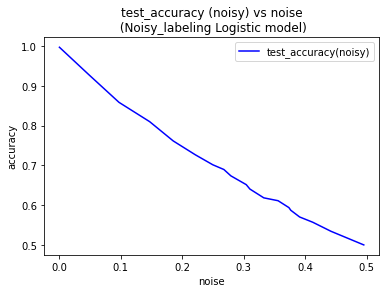

In [127]:
test_accuracy_noisy  = [model_history[i].accuracy(model_history[i].X_test, 
                                                  model_history[i].Y_test, 
                                                  model_history[i].D_test) for i in range(len(model_history))]

plt.plot(noise_list_history, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('test_accuracy (noisy) vs noise' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'test_accuracy_noisy_vs_noise', bbox_inches='tight')
plt.show()

In [128]:
np.savetxt(csv_path + "test_accuracy_noisy.csv", 
           test_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

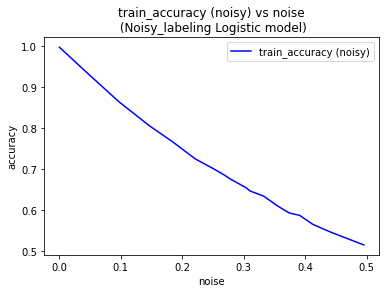

In [129]:
train_accuracy_noisy  = [model_history[i].accuracy(model_history[i].X_T, 
                                                   model_history[i].Y_T, 
                                                   model_history[i].D_T) for i in range(len(model_history))]

plt.plot(noise_list_history, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('train_accuracy (noisy) vs noise' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'train_accuracy_noisy_vs_noise', bbox_inches='tight')
plt.show()

In [130]:
np.savetxt(csv_path + "train_accuracy_noisy.csv", 
           train_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

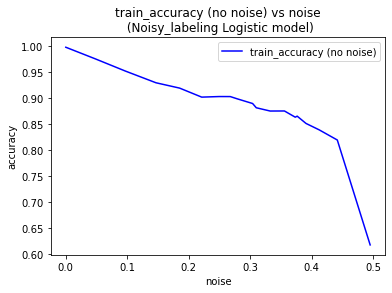

In [131]:
train_accuracy_no_noisy  = [model_history[i].accuracy(model_history[i].X_T, 
                                                      model_history[i].Y_T, 
                                                      model_history[i].D_no_noise_T) for i in range(len(model_history))]
plt.plot(noise_list_history, train_accuracy_no_noisy, label = 'train_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('train_accuracy (no noise) vs noise' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'train_accuracy_no_noise_vs_noise', bbox_inches='tight')
plt.show()

In [132]:
np.savetxt(csv_path + "train_accuracy_no_noisy.csv", 
           train_accuracy_no_noisy,
           delimiter =", ", 
           fmt ='% s')

In [133]:
noise_list_history[-1], train_accuracy_no_noisy[-1]

(0.4952857142857143, 0.6176111111111111)